In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

In [113]:
def calculate_cummulative_energy_consumption(df):

    # Determine which key to use based on available columns
    key = "PACKAGE_ENERGY (W)"  # Default key
    if "CPU_ENERGY (J)" in df.columns:
        key = "CPU_ENERGY (J)"
    elif "PACKAGE_ENERGY (J)" in df.columns:
        key = "PACKAGE_ENERGY (J)"
    elif "SYSTEM_POWER (Watts)" in df.columns:
        key = "SYSTEM_POWER (Watts)"
    
    data = df[key].copy().to_list()
    energy_time_series = []
    
    # Calculate aggregated power
    if key != "CPU_POWER (Watts)" and key != "SYSTEM_POWER (Watts)":
        df[key + "_original"] = df[key].copy()
        for i in range(0, len(data)):
            if i > 0:
                # Diff with previous value and convert to watts
                data[i] = (data[i] - df[key + "_original"][i - 1]) * (1000 / df["Delta"][i])
            else:
                data[i] = 0

            # Aggregating power (cumulative sum of the converted data)
            if i == 0:
                # 0 energy consumption for the first value
                energy_time_series.append(0)
            else:
                # Multiply power by delta time in seconds, and add the previous data
                energy_time_series.append(data[i] * (df["Delta"][i]/1000) + energy_time_series[i - 1])
    # Extract delta times
    delta_times = df["Delta"].copy().to_list()
    # Compute timestamps (cumulative sum of Delta column)
    timestamps = pd.Series([] + list(pd.Series(delta_times).cumsum())) / 1000
    # Clean up last data point which is often an outlier
    delta_times = delta_times[:-1]
    data = data[:-1]
    energy_time_series = energy_time_series[:-1]
    timestamps = timestamps[:-1]
    
    return energy_time_series, timestamps, data

In [116]:
def generate_timeseries_dataframe(folderPath):

    data_list = []  # Store all extracted data

    for sut in os.listdir(folderPath):  # Loop through SUT folders
        print(sut)
        sut_path = os.path.join(folderPath, sut)

        if os.path.isdir(sut_path):  # Ensure it's a directory
            for run in os.listdir(sut_path):  # Loop through run_1, run_2, ...
                run_path = os.path.join(sut_path, run)

                if os.path.isdir(run_path) and run.startswith("run_"):
                    experiment_number = int(run.split("_")[1])  # Extract run number

                    for csv_file in os.listdir(run_path):  # Loop through CSV files
                        if csv_file.endswith(".csv"):
                            tool_name = csv_file.replace(".csv", "")  # Extract tool name
                            file_path = os.path.join(run_path, csv_file)
                            power_aggregate = []  # To store a single time series
                            df = pd.read_csv(file_path)
                            
                            # Compute energy_time_series
                            energy_time_series, timestamps, data = calculate_cummulative_energy_consumption(df)
                            
                            # Append structured data
                            for time_idx, (timestamp, value) in enumerate(zip(timestamps, energy_time_series)):
                                data_list.append([sut, experiment_number, tool_name, time_idx, timestamp, value, data[time_idx]])
    # Create final DataFrame
    df_final = pd.DataFrame(data_list, columns=["SUT", "Experiment", "Debloated_Artifact", "Time_Index", "Timestamp", "Value", "Power"])
    df_final.to_csv("time_series_data.csv", index=False)
    return df_final

    

In [117]:
generate_timeseries_dataframe("energibridge")

jgit
zxing


,SUT,Experiment,Debloated_Artifact,Time_Index,Timestamp,Value,Power
0,jgit,1,depclean,0,0.000,0.000000,0.000000
1,jgit,1,depclean,1,0.200,0.093292,0.466461
2,jgit,1,depclean,2,0.400,3.889801,18.982544
3,jgit,1,depclean,3,0.600,8.084869,20.975342
4,jgit,1,depclean,4,0.800,12.565842,22.404861
...,...,...,...,...,...,...,...
4240,zxing,1,vanilla,508,101.536,1870.861176,17.521591
4241,zxing,1,vanilla,509,101.736,1874.651520,18.951721
4242,zxing,1,vanilla,510,101.936,1878.140533,17.445068
4243,zxing,1,vanilla,511,102.136,1881.536118,16.977921


In [147]:
# A function to generate the aggregated power time series for comparison
def generate_aggregated_power_charts_comparison(csv_files):
    # Check if all CSV files exist
    for csv_file in csv_files:
        if not os.path.exists(csv_file):
            raise ValueError(f'{csv_file} does not exist')

    power_data = []  # This will hold aggregated power values for each file
    labels = []  # This will store the file names for the legend
    
    # Iterate over each CSV file to calculate power aggregates
    for csv_file in csv_files:
        power_aggregate = []  # To store aggregated power for this file
        df = pd.read_csv(csv_file)
        
        # Get energy time series, timestamps, and data
        energy_time_series, timestamps, _ = calculate_cummulative_energy_consumption(df)

        # Append the aggregated energy consumption data for this file
        power_data.append([energy_time_series, timestamps])
        labels.append(os.path.basename(csv_file))  # Store the file name for the legend
    
    # Plot all aggregated power data
    plt.figure(figsize=(10, 6))
    
    # Generate x-axis based on the timestamps (time between measurements)
    for i, (energy_time_series, timestamps) in enumerate(power_data):
        # Plot each aggregated energy with a unique color and label
        plt.plot(timestamps, energy_time_series, label=labels[i])

    # Set the plot labels and title
    plt.xlabel("Time (seconds)")
    plt.ylabel("Aggregated Energy (Joules)")
    plt.title("Aggregated Energy Comparison Across CSV Files")
    
    # Add the legend to the plot
    plt.legend(loc='upper left')
    
    # Show the plot
    plt.tight_layout()
    plt.savefig("power_comparison.png")  # Save as PNG file
    plt.show()




In [164]:
# Code in this cell is written by the Energibridge developers
def avg_metric(df: pd.DataFrame, metric_name: str):
    all_data = None
    nb_point = 0
    # Iterate through the columns of the DataFrame
    for metric in df.columns[1:]:  # Skip the first column which is typically 'Time' or 'Delta'
        if metric_name in metric:
            nb_point += 1
            if all_data is None:
                all_data = df[metric].copy()
            else:
                all_data += df[metric]
    
    # If no matching metrics were found, return an empty Series
    if nb_point == 0:
        return pd.Series([0] * len(df))
    
    # Calculate the average
    return all_data / nb_point

def generate_metric_charts(csv_file):
    all_data = []
    if not os.path.exists(csv_file):
        raise ValueError(f'{csv_file} does not exist')
    df = pd.read_csv(csv_file)
    _, timestamps, data = calculate_cummulative_energy_consumption(df)
    data = data[1:]
    for i in range(0, len(data)):
        all_data.append({"Time": i, "CPU_POWER (Watts)": data[i]})
    # Generate x_axis based on the average delta time
    x_axis = [timestamps[i] for i in range(len(data))]
    x_axis_2 = [timestamps[i] for i in range(len(data))]
    # Now plot everything using x_axis for consistent time scaling
    fig, ax = plt.subplots(figsize=(10, 5))

    # Plot CPU Power
    ax.plot(x_axis, data, label="CPU Power")
    ax.set_ylabel('Watts')

    # Create a second y-axis for the other metrics
    ax2 = ax.twinx()

    # Plot the average temperature, usage, and memory percentage using x_axis for consistent timing
    ax2.plot(x_axis_2, avg_metric(df, "CPU_TEMP")[1:-1], label="CPU TEMP (C)", color="red")
    ax2.plot(x_axis_2, avg_metric(df, "CPU_USAGE")[1:-1], label="CPU USAGE (%)", color="orange")
    ax2.plot(x_axis_2, (df["USED_MEMORY"] * 100 / df["TOTAL_MEMORY"])[1:-1], label="Used Memory (%)", color="green")
    
    ax2.set_ylim([0, 100])

    # Set labels and legend
    ax.set(xlabel="Time (seconds)")
    fig.legend(loc='upper right')
    fig.tight_layout()

    # Show the aggregated power plot
    plt.tight_layout()
    plt.show()
    # Display the plot
    plt.show()

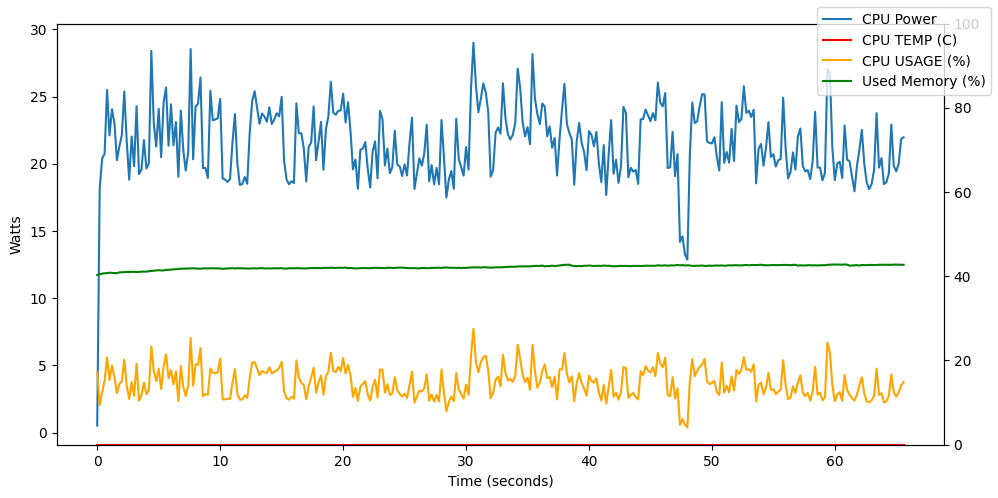

In [165]:
generate_metric_charts(os.path.join(os.getcwd(), 'energibridge/jgit/run_1/jlink.csv'))

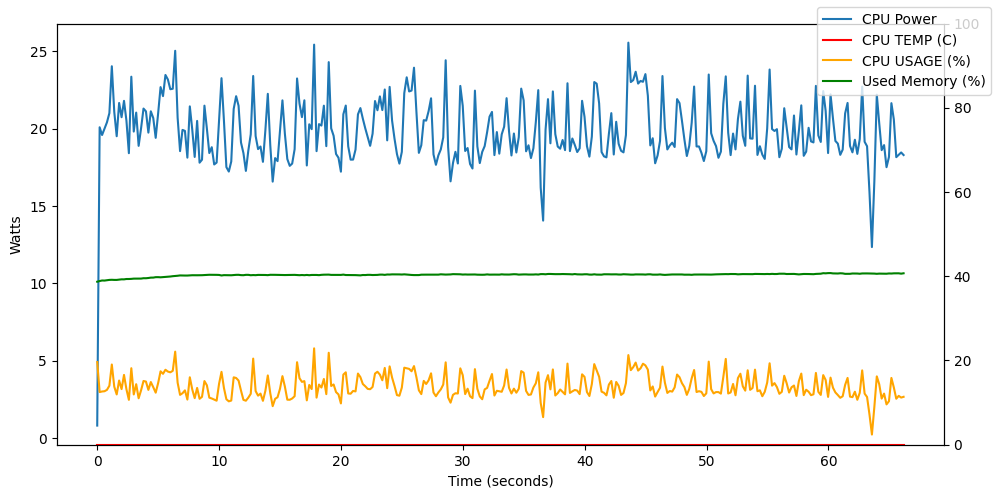

In [166]:
generate_metric_charts(os.path.join(os.getcwd(), 'energibridge/jgit/run_1/deptrim.csv'))

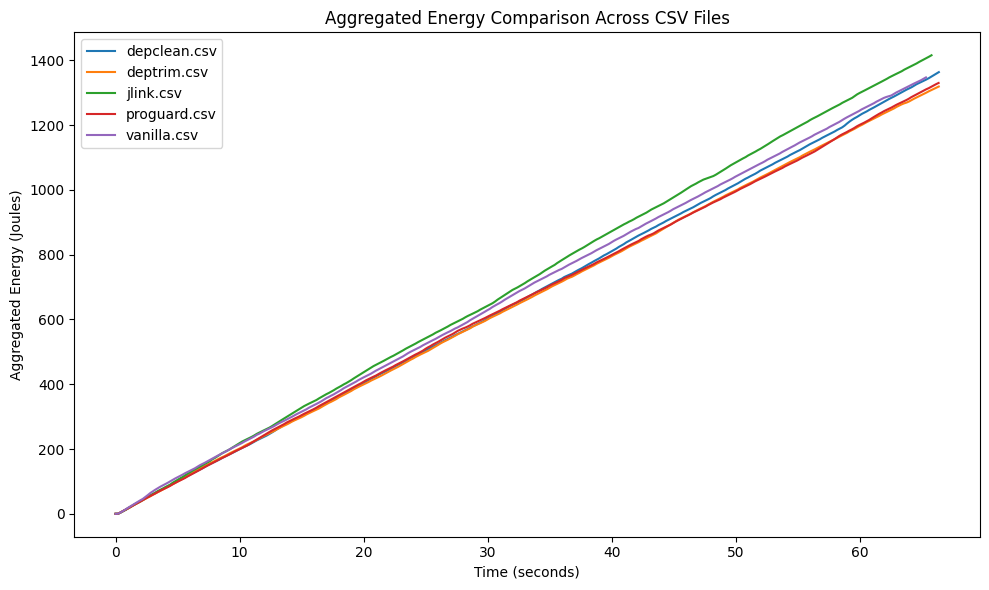

In [167]:
csv_files = glob.glob("energibridge/jgit/run_1/*.csv")
generate_aggregated_power_charts_comparison(csv_files)

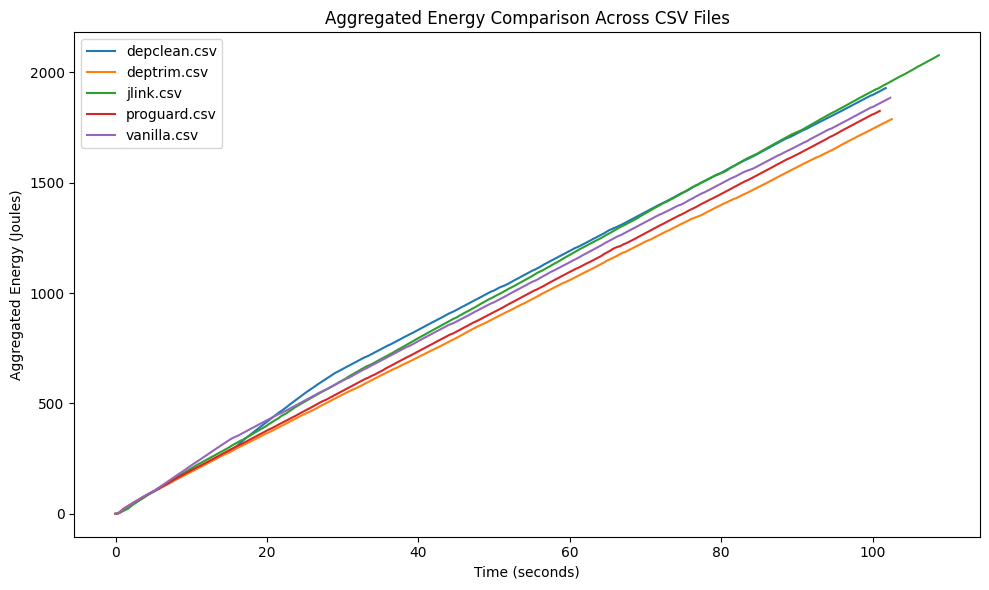

In [169]:
csv_files = glob.glob("energibridge/zxing/run_1/*.csv")
generate_aggregated_power_charts_comparison(csv_files)